# Example 1: Homework Assignment—Data Wrangling (Solutions)
In this homework assignment, you will begin to explore a data set that contains information on the infamous _Titanic_ shipwreck.  Similar to the [Kaggle competition](https://www.kaggle.com/c/titanic/overview), ultimately you are interested in using information about a passenger to predict survival.  Data were obtained from http://biostat.mc.vanderbilt.edu/DataSets.

This homework is the first part of the data analysis life cycle, in which you will extract basic information from the data set and practice common data wrangling tasks.  The analysis will continue in other lectures and homework assignments.

## Data Preparation

### Load data

#### 1. Run the following cell to load the Titanic data set from the web.

In [2]:
/* Allow n-literalized variable names with special characters */
options validvarname=any;
/* Reduce log output */
options nosource;
/* Fetch the file from the website */
filename titanic3 temp;
proc http
    url="http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv"
    method="GET"
    out=titanic3;
run;
/* Import the file */
proc import
    file=titanic3
    out=work.titanic3(rename=('home.dest'n = home_dest)) replace
    dbms=csv;
run;

### Explore basic data set information

#### 2. Display a table that contains, at a minimum, the name and type of each variable in the data set.

In [3]:
proc contents data=titanic3; 
    ods select Variables;
run;

#### Use PROC SQL for the next 5 exercises.  
#### 3. Display the first 5 rows of the data set to familiarize yourself with the variables.

In [4]:
proc sql outobs=5;
    select * from titanic3;
quit;

pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,,,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,,135,"Montreal, PQ / Chesterville, ON"
1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,,,"Montreal, PQ / Chesterville, ON"


#### 4. Display the number of rows in the data set.

In [5]:
proc sql;
    select count(*) as numObs from titanic3;
quit;

numObs
1309


#### 5. For the seven oldest females in the data set, display their names, ages, and survival status.  

In [6]:
proc sql outobs=7;
    select name, age, survived from titanic3
    where sex = 'female'
    order by age desc;
quit;      

name,age,survived
"Cavendish, Mrs. Tyrell William (Julia Florence Sieg",76,1
"Compton, Mrs. Alexander Taylor (Mary Eliza Ingersol",64,1
"Crosby, Mrs. Edward Gifford (Catherine Elizabeth Ha",64,1
"Turkula, Mrs. (Hedwig)",63,1
"Straus, Mrs. Isidor (Rosalie Ida Blun)",63,0
"Andrews, Miss. Kornelia Theodosia",63,1
"Stone, Mrs. George Nelson (Martha Evelyn)",62,1


#### 6. Determine the age (in months) of the youngest male who survived.

In [7]:
proc sql;
    select min(age)*12 as minAgeMale from titanic3
    where sex = 'male' and survived = 1;
quit;

minAgeMale
5.04


#### 7. For each gender, calculate the average age of the passengers who survived vs. those who did not.

In [8]:
proc sql;
    select sex, survived, avg(age) as avgAge 
    from titanic3
        group by sex, survived;
quit;

sex,survived,avgAge
female,0,25.25521
female,1,29.81538
male,0,31.51641
male,1,26.97778


## Partition into training and test sets
Real world data sets are typically messy and often contain missing values.  Before addressing them, we should first partition our original data set into a training set and a test set for any subsequent model building we perform.  Otherwise, "data leakage" can occur because information from the test set will be implicitly incorporated into the data that will be used for model training.

#### 8. Create a training set that contains 80% of the observations, with the remaining 20% going into the test set.  Use 20190429 as the random number seed.

In [9]:
/* Create a partition indicator variable */
proc surveyselect data=titanic3 rate=.8 out=titanic outall seed=20190429;
run;

/* Use the partition indicator to create the training and test sets */
data titanicTrain titanicTest(drop=selected);
  set titanic;
  if selected then output titanicTrain;
  else output titanicTest;
run;

Selection Method,Simple Random Sampling
Input Data Set,TITANIC3
Random Number Seed,20190429
Sampling Rate,0.8
Sample Size,1048
Selection Probability,0.800611
Sampling Weight,0
Output Data Set,TITANIC


## Missing values 
#### In this section, you will explore and address the missing values in the data set.

#### 9. In the original data set, which variables have missing values?

In [10]:
/* Count missing values for continuous variables */
proc means data=titanic3 NMISS N; 
run;

Variable,N Miss,N
pclass survived age sibsp parch fare,0 0 263 0 0 1,1309 1309 1046 1309 1309 1308


Out of the continuous variables, ``age`` and ``fare`` have missing values.  Around 20% of the ``age`` values are missing, whereas only 1 observation is missing for ``fare``.

In [11]:
/*** Count missing values for categorical variables ***/
/* Create a format for the missing character values */
proc format;
    value $missfmt ' '='Missing' other='Not Missing';
run;
 
proc freq data=titanic3; 
    format _CHAR_ $missfmt.; /* apply format for the duration of this PROC */
    tables _CHAR_ / missing missprint nocum nopercent;
run;

name,Frequency
Not Missing,1309
sex,Frequency
Not Missing,1309
ticket,Frequency
Not Missing,1309
cabin,Frequency
Missing,1014
Not Missing,295
embarked,Frequency
Missing,2


From the above output, we see that the ``cabin``, ``embarked``, ``boat``, ``body``, and ``home_dest`` variables all have missing values.  Except for ``embarked,`` the values for these variables are rather sparse.

#### 10. For each variable with missing values, address how to deal with the missing values.  Make sure to justify your actions.

Given the extent of the missingness for the ``age`` variable, we will impute the missing values instead of simply discarding them.  A histogram of ``age`` in the training set indicates that the distribution is slightly skewed.  For this reason, we chose to impute with the median age as opposed to the mean value.  


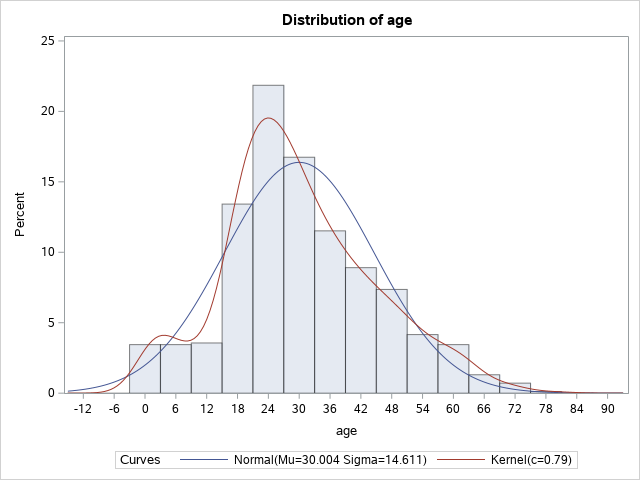

In [12]:
proc univariate data=titanicTrain;
    var age;
    histogram age / normal kernel;
    ods select Histogram;
run;

However, there is variability in the median ages for each combination of ``sex`` and ``fare`` class.

In [13]:
proc sql;
    select median(age) as medianAge, sex, pclass from titanic
    group by sex, pclass;
quit;

medianAge,sex,pclass
36,female,1
28,female,2
22,female,3
42,male,1
29.5,male,2
25,male,3


Therefore, the imputed values for ``age`` are conditional on the passenger's ``sex`` and ``pclass`` values.  The ``fare`` variable seems like it could be a useful predictor of survival.   Because only one value is missing, that observation was discarded.  The categorical variables with missing values (``cabin``, ``embarked``, ``boat``, ``body``, and ``home_dest``) intuitively do not seem like they would be good predictors of survival, so those columns are dropped from the data set.

In [14]:
/* Handle missing values for the training data */
proc sql;
    create table titanicTrainClean as 
    select coalesce(age, median(age)) as age, * from titanicTrain(drop=cabin embarked boat body home_dest)
    where fare IS NOT MISSING
    group by sex, pclass;
quit;
/* Handle missing values for the test data */
proc sql;
    create table titanicTestClean as 
    select coalesce(age, median(age)) as age, * from titanicTest(drop=cabin embarked boat body home_dest)
    where fare IS NOT MISSING
    group by sex, pclass;
quit;

#### 11. Save your clean data sets to your ``myfolders`` directory for use in future lectures and assignments.

In [15]:
proc export data=titanicTrainClean dbms=csv
    outfile="/folders/myfolders/titanicTrainClean.csv" replace;
run;
proc export data=titanicTestClean dbms=csv
    outfile="/folders/myfolders/titanicTestClean.csv" replace;
run;